# Figure 1 plots

In [61]:
import os
from pathlib import Path
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns
from Bio import Phylo
from adjustText import adjust_text
import scipy.stats as stats

cwd = os.getcwd()
if cwd.endswith('notebook'):
    os.chdir('..')
    cwd = os.getcwd()

from src.tree.tree_util import make_phylogenetic_level_tree, prune_leaves_with_unknown_id
from src.tree.itol_annotation import itol_heatmap_annotations

In [62]:
sns.set_palette('colorblind')
sns.set_style('whitegrid')
sns.set_context('paper', font_scale=1.8)
plt.rcParams['font.family'] = 'Helvetica'

palette = sns.color_palette().as_hex()

data_folder = Path('./data')
assert data_folder.is_dir()

figures_folder = Path('./figures')
assert figures_folder.is_dir()

## Heatmap

This section produces the following outputs:

- Cladogram shown on top of the heatmap (tree files in PhyloXML format)
    - Archaea: `data/figure1/ar53_phylum_groups.tree`
    - Bacteria: `data/figure1/bac120_phylum_groups.tree`
- Heatmap data in CSV format
    - `data/figure1/pgh_heatmap.csv`
- Heatmap data in [iTOL](https://itol.embl.de) format
    - Archaea: `data/figure1/ar53_phylum_heatmap.txt`
    - Bacteria: `data/figure1/bac120_phylum_heatmap.txt`

The final figure was generated with [iTOL](https://itol.embl.de) and prettified with Illustrator.

In [63]:
gtdb_metadata = pd.read_csv(data_folder / 'gtdb_metadata.csv', index_col='ncbi_accession')

In [64]:
pgh_domains = pd.read_csv(data_folder / 'pgh_domains.csv')
cw_binding_domains_set = set(pgh_domains[pgh_domains['kind'] == 'Cell wall binding']['short_name'].values)
hydrolase_domains_set = set(pgh_domains[pgh_domains['kind'] == 'Catalytic']['short_name'].values)

### Cladogram at phylum level

Cladogram apearing on top of the heatmap.

In [7]:
def is_named_phylum(phylum):
    if re.match(r'^[A-Z0-9\-_]+$', phylum) is not None:
        return False
    elif re.match(r'^.*[0-9]+.*$', phylum) is not None:
        return False
    else:
        return True
    
bacterial_named_phyla = sorted([
    p
    for p in gtdb_metadata[gtdb_metadata['domain'] == 'Bacteria']['gtdb_phylum'].unique()
    if is_named_phylum(p)
])
archaeal_named_phyla = sorted([
    p
    for p in gtdb_metadata[gtdb_metadata['domain'] == 'Archaea']['gtdb_phylum'].unique()
    if is_named_phylum(p)
])
print(f'Bacterial phyla: {len(bacterial_named_phyla):,}')
print(f'Archaeal phyla : {len(archaeal_named_phyla):,}')

Bacterial phyla: 90
Archaeal phyla : 16


In [8]:
def get_phylum_groups(phylum_list, gtdb_metadata):
    phylum_groups = {}
    for phylum in phylum_list:
        phylum_group_leader = phylum.split('_')[0]

        if phylum_group_leader not in phylum_groups:
            phylum_groups[phylum_group_leader] = []

        phylum_groups[phylum_group_leader].append(phylum)

    counts = {
        'phylum_group': [],
        'n_genomes': [],
    }
    for phylum_group in phylum_groups.keys():
        phyla = phylum_groups[phylum_group]
        c = len(gtdb_metadata[gtdb_metadata['gtdb_phylum'].isin(phyla)])
        counts['phylum_group'].append(phylum_group)
        counts['n_genomes'].append(c)

    counts_df = pd.DataFrame.from_dict(counts).set_index(
        'phylum_group', 
        drop=True,
    ).sort_values('n_genomes', ascending=False)

    return phylum_groups, counts_df

In [9]:
bacterial_phylum_groups, bacterial_phylum_group_count = get_phylum_groups(bacterial_named_phyla, gtdb_metadata)
archaeal_phylum_groups, archaeal_phylum_group_count = get_phylum_groups(archaeal_named_phyla, gtdb_metadata)
all_phylum_groups_map = bacterial_phylum_groups.copy()
all_phylum_groups_map.update(archaeal_phylum_groups)
print(f'Bacterial phylum groups: {len(bacterial_phylum_groups):,}')
print(f'Archaeal phylum groups : {len(archaeal_phylum_groups):,}')

Bacterial phylum groups: 71
Archaeal phylum groups : 15


In [10]:
gtdb_phylum_to_phylum_group = {}
for phylum_group, phyla in all_phylum_groups_map.items():
    for phylum in phyla:
        gtdb_phylum_to_phylum_group[phylum] = phylum_group

In [11]:
n = 80
df_bac_top = bacterial_phylum_group_count[bacterial_phylum_group_count['n_genomes'] >= n]
print(f'{len(df_bac_top):,} bacterial phylum groups with at least {n:,} genomes.')
top_bacterial_phylum_groups = sorted(df_bac_top.index)

34 bacterial phylum groups with at least 80 genomes.


In [12]:
gtdb_phyla = gtdb_metadata.reset_index()[['accession', 'domain', 'gtdb_phylum']].copy()
gtdb_phyla['phylum_group'] = gtdb_phyla['gtdb_phylum'].apply(
    lambda p: gtdb_phylum_to_phylum_group.get(p, p)
)
gtdb_phyla['phylum_group_strict'] = gtdb_phyla['gtdb_phylum'].apply(
    lambda p: gtdb_phylum_to_phylum_group.get(p)
)
all_phylum_groups = sorted(gtdb_phyla['phylum_group'].unique())
phylum_groups_subset = sorted([v for v in gtdb_phyla['phylum_group_strict'].unique() if not pd.isnull(v)])
len(all_phylum_groups), len(phylum_groups_subset)

(182, 86)

In [13]:
archaeal_tree = Phylo.read(data_folder / 'ar53.tree', 'phyloxml')
bacterial_tree = Phylo.read(data_folder / 'bac120.tree', 'phyloxml')

archaeal_phylum_tree = make_phylogenetic_level_tree(archaeal_tree, 'p__')
bacterial_phylum_tree = make_phylogenetic_level_tree(bacterial_tree, 'p__')

archaeal_phylum_groups_subset_tree = prune_leaves_with_unknown_id(archaeal_phylum_tree, set(phylum_groups_subset))
Phylo.write(archaeal_phylum_groups_subset_tree, data_folder / 'figure1' / 'ar53_phylum_groups.tree', 'phyloxml')

bacterial_phylum_groups_subset_tree = prune_leaves_with_unknown_id(bacterial_phylum_tree, set(top_bacterial_phylum_groups))
Phylo.write(bacterial_phylum_groups_subset_tree, data_folder / 'figure1' / 'bac120_phylum_groups.tree', 'phyloxml')

archaeal_phylum_list = sorted(set([l.name for l in archaeal_phylum_groups_subset_tree.get_terminals()]))
bacterial_phylum_list = sorted(set([l.name for l in bacterial_phylum_groups_subset_tree.get_terminals()]))
phylum_groups_on_tree = set(bacterial_phylum_list) | set(archaeal_phylum_list)

print(f'Number of archaeal phyla: {len(archaeal_phylum_list):,}')
print(f'Number of bacterial phyla: {len(bacterial_phylum_list):,}')
print(f'Total: {len(phylum_groups_on_tree):,}')

Number of archaeal phyla: 14
Number of bacterial phyla: 34
Total: 48


### Load PGH hits in archaea & bacteria

Generated with `src/search_hydrolase_from_fasta.py`

In [65]:
pgh_df = pd.read_csv(data_folder / 'pgh_proteins.csv')

pgh_df['phylum_group'] = pgh_df['gtdb_phylum'].apply(
    lambda p: gtdb_phylum_to_phylum_group.get(p, p)
)

n_pgh = len(pgh_df)
print(f'{n_pgh:,} PGH proteins')

pgh_df.head()

137,224 PGH proteins


,assembly_accession,domain,gtdb_phylum,gtdb_class,gtdb_order,gtdb_family,gtdb_genus,gtdb_species,ncbi_organism_name,protein_id,pgh_architecture,phylum_group
0,GCA_003663345.1,Archaea,Aenigmatarchaeota,Aenigmatarchaeia,PWEA01,B50-G16,B50-G16,B50-G16 sp003663345,Candidatus Aenigmarchaeota archaeon,RLJ01288.1,PG_binding_3+Glyco_hydro_108,Aenigmatarchaeota
1,GCA_018304545.1,Archaea,Aenigmatarchaeota,Aenigmatarchaeia,CG10238-14,CG10238-14,JAGVVZ01,JAGVVZ01 sp018304545,Candidatus Aenigmarchaeota archaeon,MBS3052716.1,LysM+Amidase_2,Aenigmatarchaeota
2,GCA_025058005.1,Archaea,Aenigmatarchaeota,Aenigmatarchaeia,CG10238-14,CG10238-14,JAHLMN01,JAHLMN01 sp025058005,Candidatus Aenigmarchaeota archaeon,MCS7135447.1,LysM+NLPC_P60,Aenigmatarchaeota
3,GCA_015661515.1,Archaea,Aenigmatarchaeota,Aenigmatarchaeia,Aenigmatarchaeales,SZUA-1535,SZUA-1535,SZUA-1535 sp015661515,Nanoarchaeota archaeon,HIQ49991.1,PG_binding_3+Glyco_hydro_108,Aenigmatarchaeota
4,GCA_902384455.1,Archaea,Altiarchaeota,Altiarchaeia,IMC4,SCGC-AAA252-I15,CABMCB01,CABMCB01 sp902384455,uncultured archaeon,VVB52780.1,PG_binding_3+Glyco_hydro_108,Altiarchaeota


In [15]:
pgh_df[['domain', 'assembly_accession']].groupby('domain').agg(['count', 'nunique'])

assembly_accession        
                      count nunique
domain                             
Archaea                 210     175
Bacteria             137014   42612

In [16]:
domain_architectures = sorted(pgh_df[
    (pgh_df['domain'] == 'Archaea') &
    (pgh_df['phylum_group'].isin(sorted(phylum_groups_on_tree)))
]['pgh_architecture'].unique())

print(f'Number of PGH architectures present in Archaea: {len(domain_architectures):,}')

Number of PGH architectures present in Archaea: 29


### Heatmap data

In [17]:
pgh_subset = pgh_df[pgh_df['pgh_architecture'].isin(domain_architectures)].reset_index(drop=True)
print(f'Number of PGH proteins with shared architecture between archaea and bacteria: {len(pgh_subset):,} ({100 * len(pgh_subset) / len(pgh_df):.0f} % of total)')

Number of PGH proteins with shared architecture between archaea and bacteria: 92,984 (68 % of total)


In [18]:
def apply_phylum_group(phylum):
    phylum_group = gtdb_phylum_to_phylum_group.get(phylum, 'other')
    
    if phylum_group not in phylum_groups_on_tree:
        if gtdb_metadata[gtdb_metadata['gtdb_phylum'] == phylum].iloc[0]['domain'] == 'Archaea':
            return 'other_archaea'
        else:
            return 'other_bacteria'
    else:
        return phylum_group


n_unique_accessions = pgh_subset[
    ['phylum_group', 'pgh_architecture', 'assembly_accession']
].groupby(
    ['phylum_group', 'pgh_architecture']
).nunique().rename(columns={'assembly_accession': 'n_genomes'}).reset_index()

metadata = gtdb_metadata.reset_index()[['ncbi_accession', 'gtdb_phylum', 'domain']].copy()
metadata['phylum_group'] = metadata['gtdb_phylum'].apply(apply_phylum_group)

n_total_accessions = metadata[
    ['phylum_group', 'ncbi_accession', 'domain']
].groupby(['phylum_group', 'domain']).nunique().rename(columns={'ncbi_accession': 'n_genomes_total'}).reset_index()

heatmap_df = pd.merge(
    n_total_accessions,
    n_unique_accessions,
    how='left',
    on='phylum_group',
)
heatmap_df['n_genomes'] = heatmap_df['n_genomes'].fillna(0).astype(int)
heatmap_df = heatmap_df.sort_values(['phylum_group', 'n_genomes'], ascending=[True, False]).set_index('phylum_group', drop=True)

heatmap_df['percentage'] = (100 * heatmap_df['n_genomes'] / heatmap_df['n_genomes_total']).round(3)

heatmap_df.head()

,domain,n_genomes_total,pgh_architecture,n_genomes,percentage
phylum_group,,,,,
Acidobacteriota,Bacteria,1094,LysM+SLT,929,84.918
Acidobacteriota,Bacteria,1094,AMIN+Amidase_3,632,57.770
Acidobacteriota,Bacteria,1094,SH3_4+NLPC_P60,58,5.302
Acidobacteriota,Bacteria,1094,LysM+Peptidase_M23,52,4.753
Acidobacteriota,Bacteria,1094,SH3_3+NLPC_P60,39,3.565


In [19]:
heatmap_df.to_csv(data_folder / 'figure1' / 'pgh_heatmap.csv', index=True)

In [20]:
def make_heatmap_list(heatmap_df, phylum_groups, architectures, log=False):
    heatmap_data = []
    for phylum in phylum_groups:
        row = [phylum]
        heatmap_rows = heatmap_df.loc[[phylum]].set_index('pgh_architecture', drop=True)
        existing_args = heatmap_rows.index
        for arch in architectures:
            if arch in existing_args:
                c = heatmap_rows.loc[arch, 'percentage']
                if log:
                    c = np.log10(1 + c)
            else:
                c = 0.0
            
            row.append(np.round(c, 3))

        heatmap_data.append(row)

    return heatmap_data

In [21]:
archaeal_heatmap = make_heatmap_list(heatmap_df, archaeal_phylum_list, domain_architectures)
bacterial_heatmap = make_heatmap_list(heatmap_df, bacterial_phylum_list, domain_architectures)

itol_heatmap_annotations(
    archaeal_heatmap,
    field_labels=domain_architectures,
    output_path=data_folder / 'figure1' / 'ar53_phylum_heatmap.txt',
    dataset_label='% archaeal genomes in phylum',
    color_min='#ffffff',
    color_max='#f58231',
    min_value=0,
    max_value=5,
)

itol_heatmap_annotations(
    bacterial_heatmap,
    field_labels=domain_architectures,
    output_path=data_folder / 'figure1' / 'bac120_phylum_heatmap.txt',
    dataset_label='% bacterial genomes in phylum',
    color_min='#ffffff',
    color_max='#0173b2',
    min_value=0,
    max_value=100,
)

## Signal peptide stacked bar chart

### Load signalP output

Generated from script `src/predict_signalp.py`

In [71]:
signalp_output = pd.read_csv(data_folder / 'signalp6_output.csv')
signalp_output['assembly_accession'] = signalp_output['protein_id'].apply(
    lambda p: p.split('@')[1] if '@' in p else None
)
signalp_output['protein_id'] = signalp_output['protein_id'].apply(
    lambda p: p.split('@')[0] if '@' in p else p
)
signalp_output['pathway'] = signalp_output['signal_peptide'].apply(lambda sp: sp.split('/')[0])

signalp_output.head()

,protein_id,signal_peptide,probability,cleavage_site,cleavage_site_prob,assembly_accession,pathway
0,BAC24414.1,Sec/SPII,0.987955,24-25,0.966853,GCA_000008885.1,Sec
1,BAF58967.1,Sec/SPII,0.685612,22-23,0.602861,GCA_000010565.1,Sec
2,BAF61015.1,Sec/SPI,0.998938,33-34,0.969633,GCA_000010565.1,Sec
3,BAG83382.1,Sec/SPI,0.786221,29-30,0.700540,GCA_000010645.1,Sec
4,ABG39042.1,Sec/SPI,0.868330,44-45,0.823325,GCA_000014225.1,Sec


### Add domain information to signalP output

In [74]:
signalp_dataset = pd.merge(
    signalp_output,
    gtdb_metadata.reset_index()[['ncbi_accession', 'domain']].rename(columns={
        'ncbi_accession': 'assembly_accession'
    }),
    on='assembly_accession',
    how='inner',
)
signalp_dataset.head()

,protein_id,signal_peptide,probability,cleavage_site,cleavage_site_prob,assembly_accession,pathway,domain
0,BAC24414.1,Sec/SPII,0.987955,24-25,0.966853,GCA_000008885.1,Sec,Bacteria
1,BAF58967.1,Sec/SPII,0.685612,22-23,0.602861,GCA_000010565.1,Sec,Bacteria
2,BAF61015.1,Sec/SPI,0.998938,33-34,0.969633,GCA_000010565.1,Sec,Bacteria
3,BAG83382.1,Sec/SPI,0.786221,29-30,0.700540,GCA_000010645.1,Sec,Bacteria
4,ABG39042.1,Sec/SPI,0.868330,44-45,0.823325,GCA_000014225.1,Sec,Bacteria


## Bar plot: distribution of signal peptide types in each domain

In [45]:
pathway_per_domain = signalp_dataset[
    ['domain', 'pathway', 'protein_id']
].groupby(
    ['domain', 'pathway']
).nunique().sort_values('protein_id', ascending=False)

def total_per_domain_fn():
    total_bacteria = len(pgh_df[pgh_df['domain'] == 'Bacteria'])
    total_archaea = len(pgh_df[pgh_df['domain'] == 'Archaea'])

    def fn(row):
        domain, _ = row.name
        return  total_bacteria if domain == 'Bacteria' else total_archaea

    return fn

pathway_per_domain['total'] = pathway_per_domain.apply(total_per_domain_fn(), axis=1)
pathway_per_domain['percent'] = (100 * pathway_per_domain['protein_id'] / pathway_per_domain['total']).round(2)

pathway_per_domain

protein_id   total  percent
domain   pathway                             
Bacteria Sec           83608  137014    61.02
         Tat            3354  137014     2.45
Archaea  Sec              42     210    20.00
         Tat              25     210    11.90

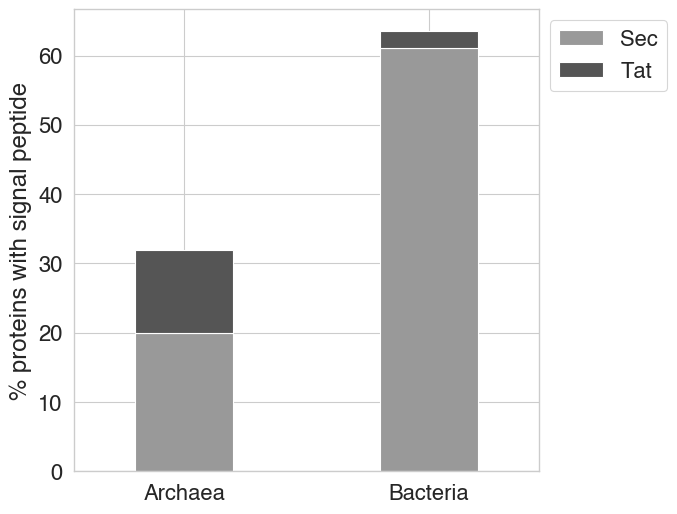

In [48]:
sp_pivot_df = pathway_per_domain.reset_index().pivot(index='domain', columns='pathway', values='percent')

f, ax = plt.subplots(1, 1, figsize=(6, 6))

sp_pivot_df.plot(kind='bar', stacked=True, ax=ax, color=['#999999', '#555555'], width=0.4);

ax.set_xlabel('');
ax.set_ylabel('% proteins with signal peptide');

plt.xticks(rotation=0);

ax.legend(bbox_to_anchor=(1, 1), loc='upper left');

f.savefig(figures_folder / 'figure1' / 'signal_peptides.pdf', dpi=300, bbox_inches='tight');

In [107]:
sp_pivot_df

pathway,Sec,Tat
domain,,
Archaea,65.45,34.55
Bacteria,91.62,8.38


## Percentage genomes per PGH architectures

Raw figure generated below. In the final figure, labels have been manually moved to prevent overlaps.

In [98]:
genomes_per_domain = heatmap_df.reset_index()[
    ['domain', 'pgh_architecture', 'n_genomes']
].groupby(
    ['domain', 'pgh_architecture']
).sum().sort_values('n_genomes', ascending=False)

def n_genomes_per_domain_fn():
    n_genomes_per_domain = gtdb_metadata.reset_index()[['domain', 'ncbi_accession']].groupby('domain').count()

    def fn(row):
        domain, _ = row.name
        return n_genomes_per_domain.loc[domain, 'ncbi_accession']

    return fn

genomes_per_domain['n_genomes_total'] = genomes_per_domain.apply(n_genomes_per_domain_fn(), axis=1)

genomes_per_domain['percent'] = (100 * genomes_per_domain['n_genomes'] / genomes_per_domain['n_genomes_total']).round(2)

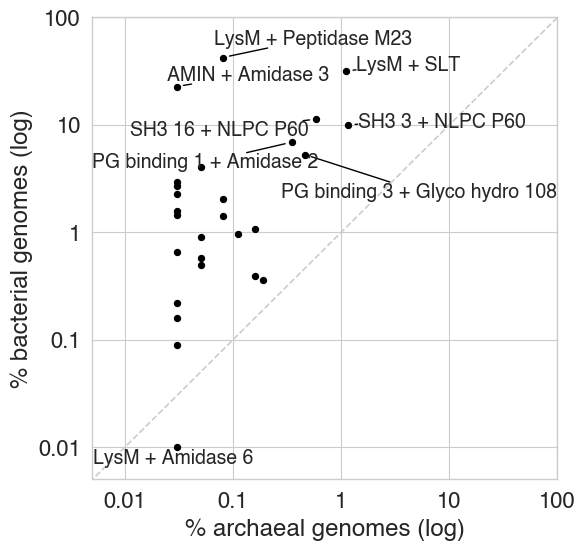

In [108]:
architecture_pivot_df = genomes_per_domain.reset_index()[
    ['domain', 'pgh_architecture', 'percent']
].pivot(index='pgh_architecture', columns='domain', values='percent')

f, ax = plt.subplots(1, 1, figsize=(6, 6))

architecture_pivot_df.plot.scatter(x='Archaea', y='Bacteria', s=20, c='#000000', ax=ax)

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlim((5e-3, 100))
ax.set_ylim((5e-3, 100))

formatter = FuncFormatter(lambda y, _: '{:g}'.format(y))
ax.yaxis.set_major_formatter(formatter)
ax.xaxis.set_major_formatter(formatter)

x = range(-10, 110)
ax.plot(x, x, '--', color='#cccccc')

ax.set_xlabel('% archaeal genomes (log)');
ax.set_ylabel('% bacterial genomes (log)');

texts = []
architectures_to_highlight = {
    'LysM+Peptidase_M23',
    'LysM+SLT',
    'AMIN+Amidase_3',
    'PG_binding_3+Glyco_hydro_108',
    'SH3_3+NLPC_P60',
    'SH3_16+NLPC_P60',
    'PG_binding_1+Amidase_2',
    'LysM+Amidase_6',
}
for i, row in architecture_pivot_df.reset_index().iterrows():
    if row['pgh_architecture'] in architectures_to_highlight:
        a = ax.text(
            row['Archaea'],
            row['Bacteria'],
            row['pgh_architecture'].replace('_', ' ').replace('+', ' + '), 
            fontsize=14, 
            ha='center',
            va='center',
        )
        texts.append(a)

adjust_text(texts, arrowprops=dict(arrowstyle='-', color='black', lw=1.0, shrinkA=0, shrinkB=5));

f.savefig(figures_folder / 'figure1' / 'pgh_abundance_genomes_raw.pdf', dpi=300, bbox_inches='tight');

In [110]:
architecture_pivot_df.to_csv(data_folder / 'figure1' / 'pgh_abundance_genomes.csv', index=True)
architecture_pivot_df

domain,Archaea,Bacteria
pgh_architecture,,
AMIN+Amidase_3,0.03,22.72
CW_7+LysM+Glyco_hydro_25,0.03,0.16
Choline_bind_1+Choline_bind_3+Amidase_3,0.03,0.22
LysM+Amidase_2,0.08,1.41
LysM+Amidase_3,0.03,2.29
LysM+Amidase_6,0.03,0.01
LysM+NLPC_P60,0.05,4.04
LysM+Peptidase_M15,0.16,0.39
LysM+Peptidase_M23,0.08,42.32


## Number of archaeal proteins in genome

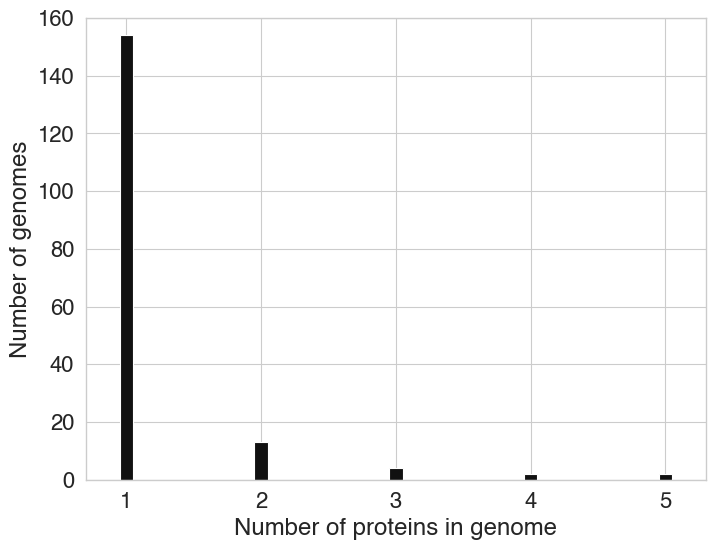

In [101]:
n_proteins_per_genome = pgh_df[
    ['domain', 'assembly_accession', 'protein_id']
].groupby(
    ['domain', 'assembly_accession']
).count().reset_index().groupby([
    'domain', 'protein_id'
]).count()

n_proteins_per_genome_arc = n_proteins_per_genome.loc['Archaea']

f, ax = plt.subplots(1, 1, figsize=(8, 6))

n_proteins_per_genome_arc.plot(kind='bar', width=0.1, ax=ax, color='#111111');
plt.xticks(rotation=0);
ax.get_legend().remove()
ax.set_ylim((None, 160));
ax.set_xlabel('Number of proteins in genome');
ax.set_ylabel('Number of genomes');

f.savefig(figures_folder / 'figure1' / 'n_PGH_per_archaeal_genomes.pdf', dpi=300, bbox_inches='tight')

In [111]:
n_proteins_per_genome_arc

,assembly_accession
protein_id,
1,154
2,13
3,4
4,2
5,2


## Plasmid vs Chromosome

How often PGH are on plasmid (or small contigs for non-complete genomes) vs chromosome, in each domain?

- Plasmid: as provided in annotation.
- Small plasmid: smaller than the median contig length for a given genome.

Processed data below originates from `src/plasmid_vs_chromosome.py`.

In [50]:
plasmid_vs_chromosome_df = pd.read_csv(data_folder / 'figure1' / 'amp_db_plasmid_vs_chromosome.csv')

plasmid_vs_chromosome_df = pd.merge(
    plasmid_vs_chromosome_df,
    gtdb_metadata[['domain', 'gtdb_phylum', 'gtdb_genus']].reset_index(),
    left_on='assembly_accession',
    right_on='ncbi_accession',
    how='left',
).set_index('assembly_accession', drop=True).drop(columns=['ncbi_accession'])

plasmid_vs_chromosome_df = plasmid_vs_chromosome_df.loc[
    sorted(set(pgh_df['assembly_accession'].values) & set(plasmid_vs_chromosome_df.index))
]
plasmid_vs_chromosome_df = plasmid_vs_chromosome_df[plasmid_vs_chromosome_df['protein_id'].isin(pgh_df['protein_id'].unique())]
plasmid_vs_chromosome_df = plasmid_vs_chromosome_df.reset_index().drop_duplicates(['assembly_accession', 'protein_id'])
plasmid_vs_chromosome_df = plasmid_vs_chromosome_df.set_index('assembly_accession', drop=True)
plasmid_vs_chromosome_df['below_median_length'] = plasmid_vs_chromosome_df.apply(
    lambda row: row['contig_length'] < row['median_contig_length'] if not pd.isnull(row['contig_length']) else False,
    axis=1,
)
plasmid_vs_chromosome_df.head()

,protein_id,contig_id,contig_length,median_contig_length,location,domain,gtdb_phylum,gtdb_genus,below_median_length
assembly_accession,,,,,,,,,
GCA_000007325.1,AAL94370.1,AE009951.2,2174500.0,2174500.0,Chromosome,Bacteria,Fusobacteriota,Fusobacterium,False
GCA_000007325.1,AAL94673.1,AE009951.2,2174500.0,2174500.0,Chromosome,Bacteria,Fusobacteriota,Fusobacterium,False
GCA_000008885.1,BAC24414.1,BA000021.3,697724.0,351502.0,Chromosome,Bacteria,Pseudomonadota,Wigglesworthia,False
GCA_000010565.1,BAF58967.1,AP009389.1,3025375.0,3025375.0,Chromosome,Bacteria,Bacillota_B,Pelotomaculum,False
GCA_000010565.1,BAF60354.1,AP009389.1,3025375.0,3025375.0,Chromosome,Bacteria,Bacillota_B,Pelotomaculum,False


In [51]:
grouped = plasmid_vs_chromosome_df[
    plasmid_vs_chromosome_df['contig_length'].notnull()
][
    ['domain', 'location', 'protein_id']
].groupby(['domain', 'location'], dropna=False).count()
grouped

protein_id
domain   location              
Archaea  Chromosome          14
         Plasmid              4
         NaN                115
Bacteria Chromosome       13684
         Plasmid            102
         NaN              84132

In [52]:
arc_plasmid = grouped.loc[('Archaea', 'Plasmid'), 'protein_id']
arc_chromosome = grouped.loc[('Archaea', 'Chromosome'), 'protein_id']

bac_plasmid = grouped.loc[('Bacteria', 'Plasmid'), 'protein_id']
bac_chromosome = grouped.loc[('Bacteria', 'Chromosome'), 'protein_id']

arc_p_plasmid = 100 * arc_plasmid / (arc_plasmid + arc_chromosome)
bac_p_plasmid = 100 * bac_plasmid / (bac_plasmid + bac_chromosome)

contingency_table = [[arc_plasmid, arc_chromosome], [bac_plasmid, bac_chromosome]]
_, p_value_plasmid = stats.fisher_exact(contingency_table)

print(f'Percentage of archaeal PGH genes on plasmid: {arc_p_plasmid:.2f}% ({arc_plasmid:,} out of {arc_plasmid + arc_chromosome:,})')
print(f'Percentage of bacterial PGH genes on plasmid: {bac_p_plasmid:.2f}% ({bac_plasmid:,} out of {bac_plasmid + bac_chromosome:,})')
print(f'P-value: {p_value_plasmid:.2e}')

Percentage of archaeal PGH genes on plasmid: 22.22% (4 out of 18)
Percentage of bacterial PGH genes on plasmid: 0.74% (102 out of 13,786)
P-value: 9.25e-06


In [53]:
contig_grouped = plasmid_vs_chromosome_df[
    plasmid_vs_chromosome_df['contig_length'].notnull()
][
    ['domain', 'below_median_length', 'protein_id']
].groupby(['domain', 'below_median_length'], dropna=False).count()
contig_grouped

protein_id
domain   below_median_length            
Archaea  False                       107
         True                         26
Bacteria False                     89626
         True                       8292

In [54]:
arc_below = contig_grouped.loc[('Archaea', True), 'protein_id']
arc_above = contig_grouped.loc[('Archaea', False), 'protein_id']

bac_below = contig_grouped.loc[('Bacteria', True), 'protein_id']
bac_above = contig_grouped.loc[('Bacteria', False), 'protein_id']

arc_p_contig = 100 * arc_below / (arc_below + arc_above)
bac_p_contig = 100 * bac_below / (bac_below + bac_above)

contingency_table = [[arc_below, arc_above], [bac_below, bac_above]]
_, p_value_contig = stats.fisher_exact(contingency_table)

print(f'Percentage of archaeal PGH genes on small contig: {arc_p_contig:.2f}% ({arc_below:,} out of {arc_below + arc_above:,})')
print(f'Percentage of bacterial PGH genes on small contig: {bac_p_contig:.2f}% ({bac_below:,} out of {bac_below + bac_above:,})')
print(f'P-value: {p_value_contig:.2e}')

Percentage of archaeal PGH genes on small contig: 19.55% (26 out of 133)
Percentage of bacterial PGH genes on small contig: 8.47% (8,292 out of 97,918)
P-value: 5.63e-05


Fisher's exact test P-value: 8.88e-07


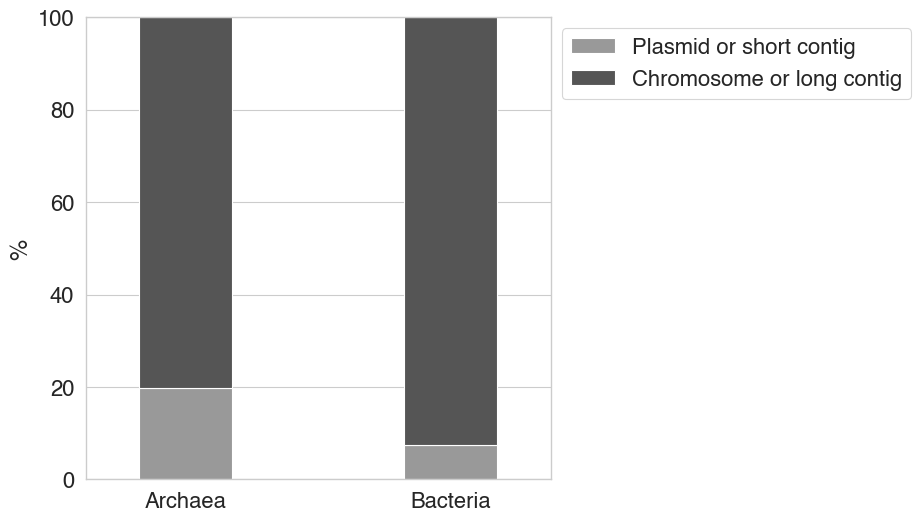

In [60]:
data = {
    'Plasmid or short contig': [arc_plasmid + arc_below, bac_plasmid + bac_below],
    'Chromosome or long contig': [arc_chromosome + arc_above, bac_chromosome + bac_above],
}
df = pd.DataFrame(data, index=['Archaea', 'Bacteria'])

# Calculate the percentages
totals = df.sum(axis=1)
percentages = df.div(totals, axis=0) * 100

# Calculate Fisher's exact test p-value
_, p_value = stats.fisher_exact(df.values)

# Plotting the data
f, ax = plt.subplots(1, 1, figsize=(6, 6))

# Define bar width and positions
bar_width = 0.35
index = np.arange(len(df))

# Create grouped bar chart for percentages
bar1 = ax.bar(index, percentages['Plasmid or short contig'], bar_width, label='Plasmid or short contig', color='#999999')
bar2 = ax.bar(index, percentages['Chromosome or long contig'], bar_width, bottom=percentages['Plasmid or short contig'], label='Chromosome or long contig', color='#555555')

ax.set_ylim((None, 100));

# Labeling and aesthetics
ax.margins(x=0.15)
ax.set_ylabel('%')
ax.set_xlabel('')
ax.set_xticks(index)
ax.set_xticklabels(df.index)
ax.legend(bbox_to_anchor=(1, 1), loc='upper left');

print(f'Fisher\'s exact test P-value: {p_value:.2e}')

f.savefig(figures_folder / 'figure1' / 'plasmid_vs_chromosome.pdf', dpi=300, bbox_inches='tight', transparent=True);